# Example 3

The focus of this example is converting synthetic IT ticket data into a process architecture.

**Use Case**: Convert semi-structured events into a system proces diagram

## Workflow

- Parse historical logs into PM4PY format
- Run Process mining algorithm
- Identify anomalies
- Token-based replay for simulation?

In [66]:
import pandas as pd
import pm4py
from IPython.display import display, Image

In [67]:
""""Parse CSV log into PM4PY format."""

dataframe = pd.read_csv("./synthetic_data.csv")
dataframe = pm4py.format_dataframe(
    dataframe, case_id="ticket_id", activity_key="activity", timestamp_key="timestamp"
)
event_log = pm4py.convert_to_event_log(dataframe)

dataframe.head()

,event_id,timestamp,ticket_id,activity,assigned_to,priority,category,department,notes,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,1,2024-01-15 08:42:13+00:00,TKT-20240115-001,Ticket Created,Unassigned,Medium,Software,Finance,Excel crashing when opening large files,TKT-20240115-001,Ticket Created,2024-01-15 08:42:13+00:00,0,0
1,2,2024-01-15 08:55:28+00:00,TKT-20240115-001,Ticket Assigned,Pat Anderson,Medium,Software,Finance,Assigned to L1 support,TKT-20240115-001,Ticket Assigned,2024-01-15 08:55:28+00:00,1,0
2,3,2024-01-15 09:10:45+00:00,TKT-20240115-001,Work Started,Pat Anderson,Medium,Software,Finance,Checking Office version and updates,TKT-20240115-001,Work Started,2024-01-15 09:10:45+00:00,2,0
3,4,2024-01-15 10:22:30+00:00,TKT-20240115-001,Ticket Resolved,Pat Anderson,Medium,Software,Finance,Increased memory allocation in Excel settings,TKT-20240115-001,Ticket Resolved,2024-01-15 10:22:30+00:00,3,0
4,5,2024-01-15 10:35:12+00:00,TKT-20240115-001,Ticket Closed,Pat Anderson,Medium,Software,Finance,User confirmed issue resolved,TKT-20240115-001,Ticket Closed,2024-01-15 10:35:12+00:00,4,0


Performance DFG saved to: ./example_3_dfg_performance.png


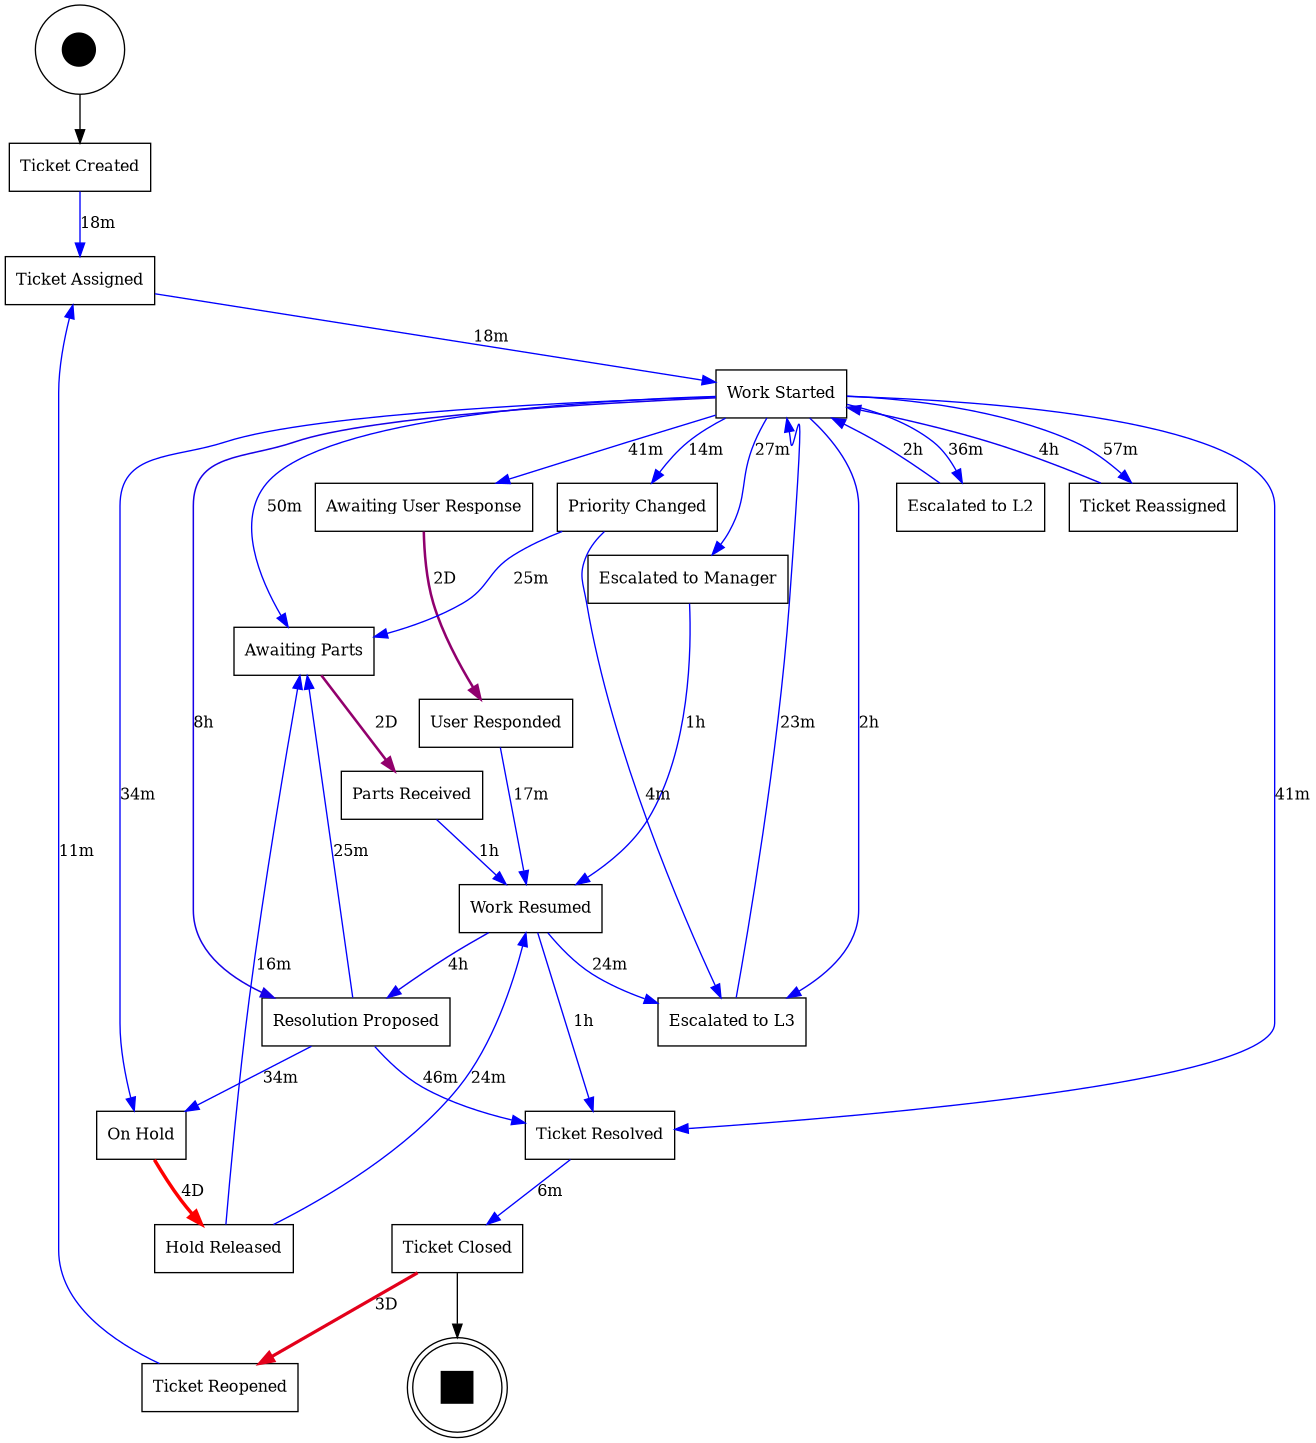

In [68]:
"""Analyze data using inductive mining."""

# Discover performance DFG - returns tuple (dfg_dict, start_activities, end_activities)
dfg, sa, ea = pm4py.discover_performance_dfg(event_log)

# Visualize with performance (time) annotations
filename = f"./example_3_dfg_performance.png"
pm4py.save_vis_performance_dfg(dfg, sa, ea, str(filename), rankdir="TD")
print(f"Performance DFG saved to: {filename}")

display(Image(filename, width=800))

DFG markov saved to: ./example_3_dfg_markov.png


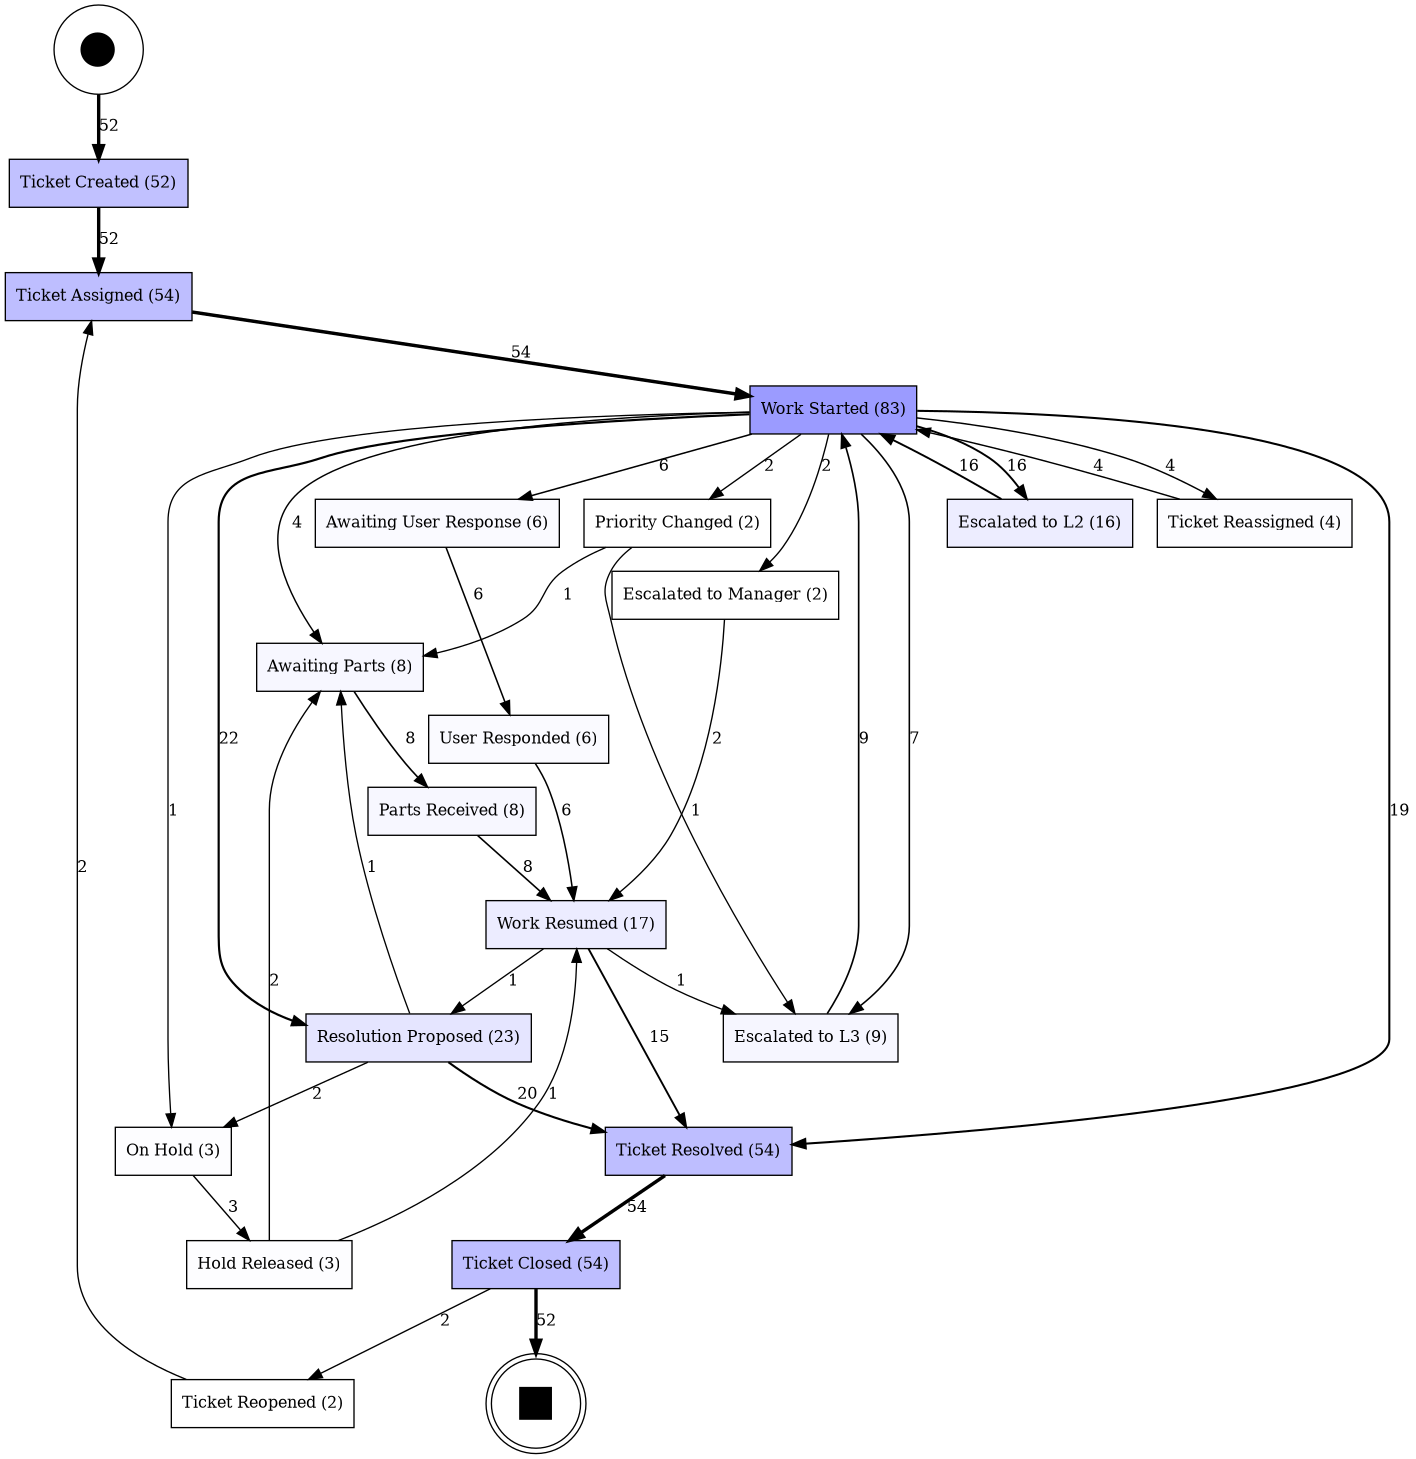

In [69]:
"""Generate a Directly follows graph as a markov chain, visualizing the variant flows."""
dfg, sa, ea = pm4py.discover_directly_follows_graph(event_log)

# Visualize with performance (time) annotations
filename = f"./example_3_dfg_markov.png"
pm4py.save_vis_dfg(dfg, sa, ea, str(filename), rankdir="TD")
print(f"DFG markov saved to: {filename}")

display(Image(filename, width=800))

In [70]:
"""Mine the roles and responsibilities.

The following categories are appropriate to run the mining process on: assigned_to,priority,category
https://processintelligence.solutions/static/api/2.7.17/pm4py.html#pm4py.org.discover_organizational_roles
https://andrea.burattin.net/public-files/publications/2013-cidm.pdf
"""

roles = pm4py.discover_organizational_roles(
    event_log,
    resource_key="assigned_to",
    activity_key="concept:name",
    timestamp_key="time:timestamp",
    case_id_key="case:concept:name",
)

In [71]:
"""Use Variants to create nominal and alternate paths.

https://processintelligence.solutions/pm4py/examples/filtering-event-data#filtering-on-variants"""

variants = pm4py.get_variants(
    event_log,
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp'
)

# Calculate stats
total_cases = len(event_log)
variant_stats = [
    {
        'Variant': variant,
        'Count': len(cases),
        'Percentage': round((len(cases) / total_cases) * 100, 2)
    }
    for variant, cases in variants.items()
]

# Display as sorted DataFrame

variant_stats_df = pd.DataFrame(variant_stats).sort_values('Count', ascending=False)
variant_stats_df['Variant'] = variant_stats_df['Variant'].astype(str).str.replace(',', ' ->')
pd.set_option('display.max_colwidth', 100)
variant_stats_df

,Variant,Count,Percentage
0,('Ticket Created' -> 'Ticket Assigned' -> 'Work Started' -> 'Ticket Resolved' -> 'Ticket Closed'),15,28.85
4,('Ticket Created' -> 'Ticket Assigned' -> 'Work Started' -> 'Awaiting User Response' -> 'User Re...,6,11.54
10,('Ticket Created' -> 'Ticket Assigned' -> 'Work Started' -> 'Escalated to L2' -> 'Work Started' ...,6,11.54
2,('Ticket Created' -> 'Ticket Assigned' -> 'Work Started' -> 'Escalated to L3' -> 'Work Started' ...,5,9.62
3,('Ticket Created' -> 'Ticket Assigned' -> 'Work Started' -> 'Awaiting Parts' -> 'Parts Received'...,2,3.85
14,('Ticket Created' -> 'Ticket Assigned' -> 'Work Started' -> 'Resolution Proposed' -> 'Ticket Res...,2,3.85
1,('Ticket Created' -> 'Ticket Assigned' -> 'Work Started' -> 'Escalated to L2' -> 'Work Started' ...,2,3.85
12,('Ticket Created' -> 'Ticket Assigned' -> 'Work Started' -> 'Ticket Reassigned' -> 'Work Started...,2,3.85
13,('Ticket Created' -> 'Ticket Assigned' -> 'Work Started' -> 'Ticket Resolved' -> 'Ticket Closed'...,1,1.92
18,('Ticket Created' -> 'Ticket Assigned' -> 'Work Started' -> 'Escalated to L2' -> 'Work Started' ...,1,1.92


# Cycle Time and Waiting Time Analysis

[Link](https://processintelligence.solutions/pm4py/examples/statistics)

PM4PY can calculate cycle time and lead time metrics for each event:

- **@@approx_bh_partial_cycle_time**: Incremental cycle time associated with the event (the cycle time of the last event is the cycle time of the instance)
- **@@approx_bh_partial_lead_time**: Incremental lead time associated with the event
- **@@approx_bh_overall_wasted_time**: Difference between partial lead time and partial cycle time values
- **@@approx_bh_this_wasted_time**: Wasted time for the activity defined by the 'interval' event
- **@approx_bh_ratio_cycle_lead_time**: Measures the incremental Flow Rate (between 0 and 1)

In [72]:
from pm4py.objects.log.util import interval_lifecycle

# Enrich the event log with cycle time and lead time metrics
enriched_log = interval_lifecycle.assign_lead_cycle_time(event_log)

# Extract the last event (closure)
enriched_log_df = pd.DataFrame([item[-1] for item in enriched_log])

# Display sample of enriched data
enriched_log_df.head()

,@@approx_bh_overall_wasted_time,@@approx_bh_partial_cycle_time,@@approx_bh_partial_lead_time,@@approx_bh_this_wasted_time,@@case_index,@@duration,@@index,@approx_bh_ratio_cycle_lead_time,activity,assigned_to,...,category,concept:name,department,event_id,notes,priority,start_timestamp,ticket_id,time:timestamp,timestamp
0,6779.0,0.0,6779.0,762.0,0,0.0,4,0.0,Ticket Closed,Pat Anderson,...,Software,Ticket Closed,Finance,5,User confirmed issue resolved,Medium,2024-01-15 10:35:12+00:00,TKT-20240115-001,2024-01-15 10:35:12+00:00,2024-01-15 10:35:12+00:00
1,135289.0,0.0,135289.0,912.0,1,0.0,17,0.0,Ticket Closed,Taylor Chen,...,Network,Ticket Closed,Engineering,18,Team confirmed VPN working properly,High,2024-01-18 16:50:22+00:00,TKT-20240115-002,2024-01-18 16:50:22+00:00,2024-01-18 16:50:22+00:00
2,4660.0,0.0,4660.0,275.0,2,0.0,22,0.0,Ticket Closed,Sam Williams,...,Access,Ticket Closed,HR,23,User able to login successfully,Low,2024-01-15 12:40:20+00:00,TKT-20240115-003,2024-01-15 12:40:20+00:00,2024-01-15 12:40:20+00:00
3,0.0,0.0,0.0,0.0,3,0.0,30,1.0,Ticket Closed,Casey Brown,...,Software,Ticket Closed,Operations,31,Post-incident review scheduled,Critical,2024-01-16 06:20:33+00:00,TKT-20240116-001,2024-01-16 06:20:33+00:00,2024-01-16 06:20:33+00:00
4,128965.0,0.0,128965.0,288.0,4,0.0,38,0.0,Ticket Closed,Chris Johnson,...,Hardware,Ticket Closed,Sales,39,User confirmed all keys working,Medium,2024-01-19 15:20:10+00:00,TKT-20240116-002,2024-01-19 15:20:10+00:00,2024-01-19 15:20:10+00:00


## Aggregate Metrics by Priority Level

Analyze how ticket priority affects cycle time and efficiency.

In [73]:
# Aggregate by priority - only use the last event of each case (total ticket cycle time)
priority_metrics = (
    enriched_log_df.groupby("priority")
    .agg(
        {
            "@@approx_bh_partial_cycle_time": [
                "mean",
                "median",
                "std",
                "min",
                "max",
                "count",
            ],
            "@@approx_bh_overall_wasted_time": ["mean", "median", "std"],
            "@approx_bh_ratio_cycle_lead_time": ["mean", "median"],
        }
    )
    .round(2)
)

priority_metrics

@@approx_bh_partial_cycle_time                              \
                                   mean median  std  min  max count   
priority                                                              
Critical                            0.0    0.0  0.0  0.0  0.0     6   
High                                0.0    0.0  0.0  0.0  0.0    12   
Low                                 0.0    0.0  0.0  0.0  0.0    16   
Medium                              0.0    0.0  0.0  0.0  0.0    18   

         @@approx_bh_overall_wasted_time                     \
                                    mean   median       std   
priority                                                      
Critical                        15935.83  14852.5  12079.13   
High                            55624.83  25287.5  60892.53   
Low                             22621.25   5102.5  51395.27   
Medium                          49966.33  21302.5  53858.33   

         @approx_bh_ratio_cycle_lead_time         
                                     mean median  
priority                                          
Critical                             0.17    0.0  
High                                 0.00    0.0  
Low                                  0.00    0.0  
Medium                               0.00    0.0

## Aggregate Metrics by Category

Compare cycle times across different ticket categories (Hardware, Software, Network, etc.).

In [74]:
category_metrics = (
    enriched_log_df.groupby("category")
    .agg(
        {
            "@@approx_bh_partial_cycle_time": [
                "mean",
                "median",
                "std",
                "min",
                "max",
                "count",
            ],
            "@@approx_bh_overall_wasted_time": ["mean", "median", "std"],
            "@approx_bh_ratio_cycle_lead_time": ["mean", "median"],
        }
    )
    .round(2)
)

category_metrics

@@approx_bh_partial_cycle_time                              \
                                      mean median  std  min  max count   
category                                                                 
Access                                 0.0    0.0  0.0  0.0  0.0     8   
Hardware                               0.0    0.0  0.0  0.0  0.0     9   
Network                                0.0    0.0  0.0  0.0  0.0     8   
Performance                            0.0    0.0  0.0  0.0  0.0     6   
Security                               0.0    0.0  0.0  0.0  0.0     5   
Software                               0.0    0.0  0.0  0.0  0.0    16   

            @@approx_bh_overall_wasted_time                     \
                                       mean   median       std   
category                                                         
Access                             45883.75  11540.0  56857.73   
Hardware                           55385.56  33185.0  57542.61   
Network                            36236.75  15885.0  45298.48   
Performance                        46058.67  27177.5  57210.25   
Security                           16702.40  13062.0  11962.45   
Software                           31821.81   6974.5  61389.60   

            @approx_bh_ratio_cycle_lead_time         
                                        mean median  
category                                             
Access                                  0.00    0.0  
Hardware                                0.00    0.0  
Network                                 0.00    0.0  
Performance                             0.00    0.0  
Security                                0.00    0.0  
Software                                0.06    0.0

## Aggregate Metrics by Assigned Technician

Analyze technician performance and workload distribution.

In [75]:
tech_metrics = (
    enriched_log_df.groupby("assigned_to")
    .agg(
        {
            "@@approx_bh_overall_wasted_time": ["mean", "median"],
            "@approx_bh_ratio_cycle_lead_time": ["mean"],
        }
    )
    .round(2)
)

tech_metrics

@@approx_bh_overall_wasted_time           \
                                          mean   median   
assigned_to                                               
Alex Martinez                         59325.50  27390.0   
Casey Brown                           44236.17  29370.0   
Chris Johnson                         46278.33   5675.0   
Jordan Lee                            23525.00  23130.0   
Morgan Davis                          53597.43  18300.0   
Pat Anderson                          32016.12   5857.5   
Riley Thompson                        13186.67  10815.0   
Sam Williams                           5022.86   4825.0   
Taylor Chen                           50066.80  19680.0   

               @approx_bh_ratio_cycle_lead_time  
                                           mean  
assigned_to                                      
Alex Martinez                              0.00  
Casey Brown                                0.17  
Chris Johnson                              0.00  
Jordan Lee                                 0.00  
Morgan Davis                               0.00  
Pat Anderson                               0.00  
Riley Thompson                             0.00  
Sam Williams                               0.00  
Taylor Chen                                0.00

## Overall Summary Statistics

Key metrics across all tickets.

In [76]:
# Overall summary statistics
overall_stats = {
    "Total Tickets": len(enriched_log_df),
    "Avg Cycle Time (hours)": round(
        enriched_log_df["@@approx_bh_partial_cycle_time"].mean() / 3600, 2
    ),
    "Median Cycle Time (hours)": round(
        enriched_log_df["@@approx_bh_partial_cycle_time"].median() / 3600, 2
    ),
    "Avg Wasted Time (hours)": round(
        enriched_log_df["@@approx_bh_overall_wasted_time"].mean() / 3600, 2
    ),
    "Avg Flow Rate": round(
        enriched_log_df["@approx_bh_ratio_cycle_lead_time"].mean(), 4
    ),
}

print("Overall Summary Statistics:")
print("=" * 80)
for key, value in overall_stats.items():
    print(f"{key:30s}: {value}")

Overall Summary Statistics:
Total Tickets                 : 52
Avg Cycle Time (hours)        : 0.0
Median Cycle Time (hours)     : 0.0
Avg Wasted Time (hours)       : 10.81
Avg Flow Rate                 : 0.0192
